In this project we will try to build a Speech Emotion Detector (SER) in which we try to classify the emotion of the human being from its speech using modulations in tone and pitch. 

In [83]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split

#for playing the audios
from IPython.display import Audio

import keras  
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, BatchNormalization, Dropout, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [4]:
#importing our dataset
from google.colab import files
upload = files.upload()

Saving RAVDESS.zip to RAVDESS.zip


In [9]:
%cd /content
!unzip RAVDESS.zip

/content
Archive:  RAVDESS.zip
   creating: RAVDESS/Actor_01/
  inflating: RAVDESS/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: RAVDESS/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: RAVDESS/Actor_01/03-01-03-01-02-02-01.wav  
  inflating: RAVDESS/Actor

Here is the filename identifiers as per the official RAVDESS website: \
 \
 
1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
2. Vocal channel (01 = speech, 02 = song).
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
5. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
 \
  \
  
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02) \
    Speech (01) \
    Fearful (06) \
    Normal intensity (01)  \ 
    Statement "dogs" (02) \
    1st Repetition (01) \
    12th Actor (12) - Female (as the actor ID number is even)


In [14]:
%cd

/root


In [24]:
ravdess_directory_list = os.listdir(path='/content/RAVDESS')
print(ravdess_directory_list)
file_emotion = []
file_path =[]

#since we have 20 different actors we need to extract files for each actor
for dir in ravdess_directory_list:
  actor = os.listdir(path='/content/RAVDESS/' + dir)
  for files in actor:
    part = files.split('.'[0])
    part = files.split('-')
    #the third part of the file represents the emotion associated with that file
    file_emotion.append(int(part[2]))
    file_path.append('/content/RAVDESS/' + dir + '/' + files)

emotion_df = pd.DataFrame(file_emotion,columns = ['Emotions'])
    
#dataframe for the path of files
path_df = pd.DataFrame(file_path, columns=['Paths'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

#changing the interger value to true emotions 
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

['Actor_07', 'Actor_05', 'Actor_16', 'Actor_12', 'Actor_22', 'Actor_17', 'Actor_08', 'Actor_19', 'Actor_10', 'Actor_23', 'Actor_24', 'Actor_21', 'Actor_04', 'Actor_18', 'Actor_15', 'Actor_13', 'Actor_20', 'Actor_09', 'Actor_01', 'Actor_03', 'Actor_02', 'Actor_06', 'Actor_14', 'Actor_11']


,Emotions,Paths
0,sad,/content/RAVDESS/Actor_07/03-01-04-01-01-02-07...
1,surprise,/content/RAVDESS/Actor_07/03-01-08-02-01-01-07...
2,happy,/content/RAVDESS/Actor_07/03-01-03-02-02-02-07...
3,fear,/content/RAVDESS/Actor_07/03-01-06-01-02-01-07...
4,surprise,/content/RAVDESS/Actor_07/03-01-08-02-02-01-07...


In [28]:
#creating a csv file from our dataset
%cd /content
ravdess_df.to_csv('ravdess.csv',index=False)
ravdess_df.head()

/content


,Emotions,Paths
0,sad,/content/RAVDESS/Actor_07/03-01-04-01-01-02-07...
1,surprise,/content/RAVDESS/Actor_07/03-01-08-02-01-01-07...
2,happy,/content/RAVDESS/Actor_07/03-01-03-02-02-02-07...
3,fear,/content/RAVDESS/Actor_07/03-01-06-01-02-01-07...
4,surprise,/content/RAVDESS/Actor_07/03-01-08-02-02-01-07...


## DATA VISUALIZATION AND EXPLORATION


#### Ploting the count of emotions
countplot to see the distribution of data

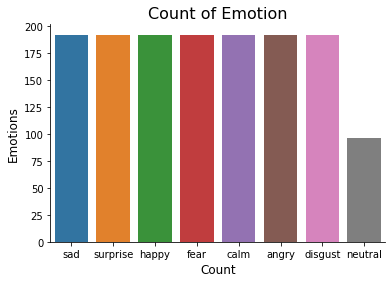

In [29]:
plt.title('Count of Emotion', size=16)
sns.countplot(ravdess_df.Emotions)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

#### Ploting the waveform of the audio signal
Wave plots help us know the loudness of the audio at a given time

In [41]:
def create_waveform(data, sr, e):   #sr- sampling rate
  plt.figure(figsize=(15,5))
  plt.title("Waveplot for audio with "+e+' Emotion', size=15)
  librosa.display.waveplot(data, sr= sr)
  plt.show()

#### Ploting a Spectrogram for the audio
A Spectrogram is a visual representation of the spectrum of frequnecies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to to time for given audio/mi=usic signal. 

In [42]:
def create_spectrogram(data, sr, e):
  #stft funtions converts the data into short term fourier transform
  X =  librosa.stft(data)
  Xdb =  librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12,8))
  plt.title('Specrtogram for audio with '+e+'Emotion', size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

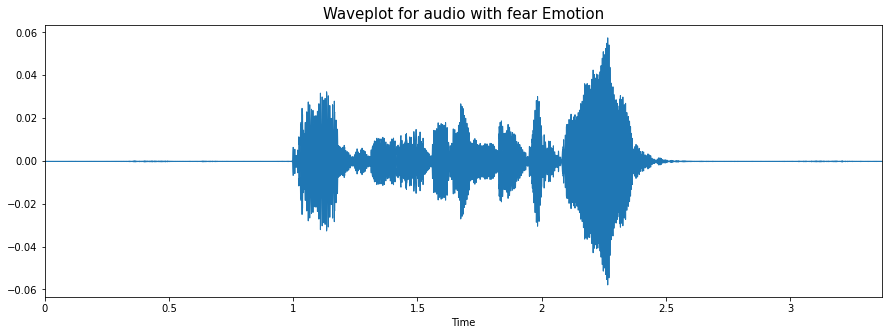

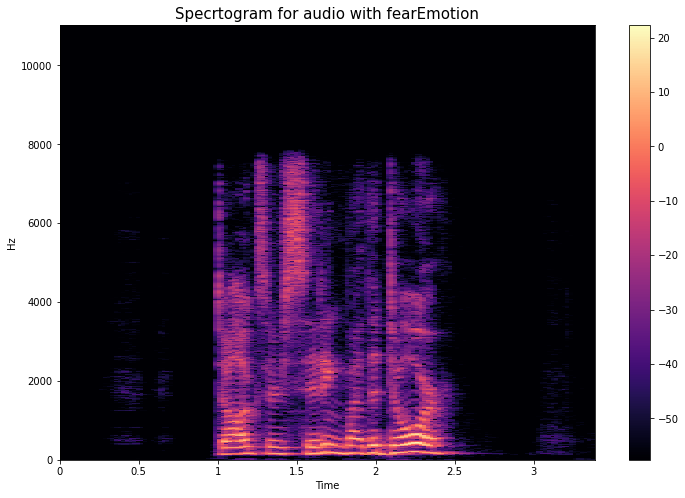

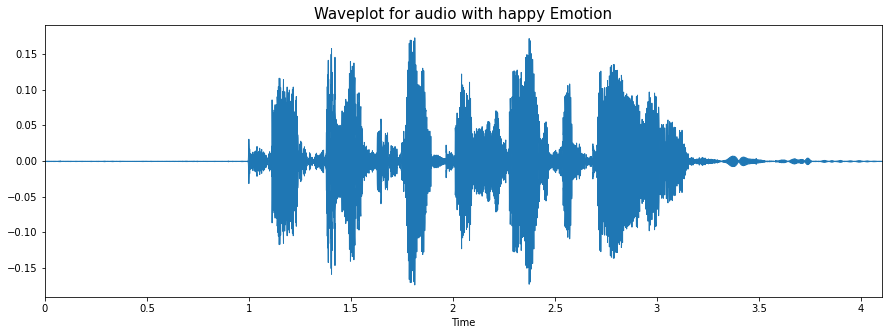

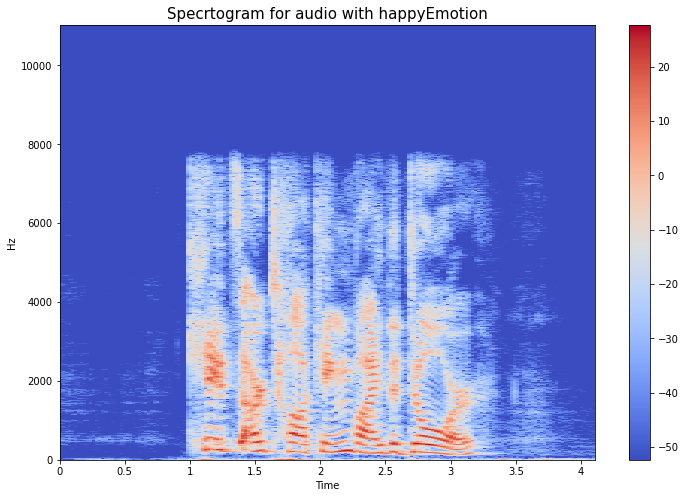

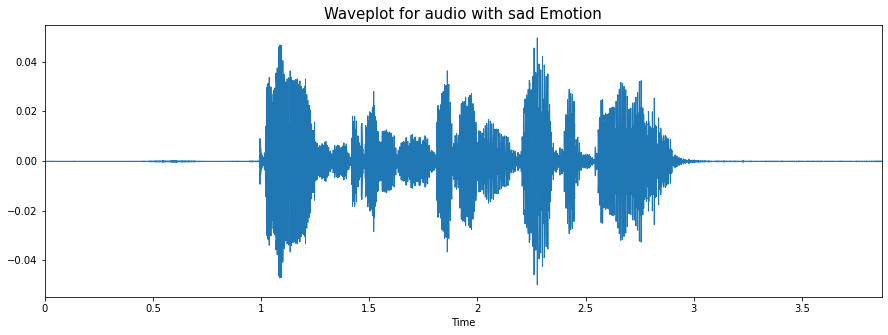

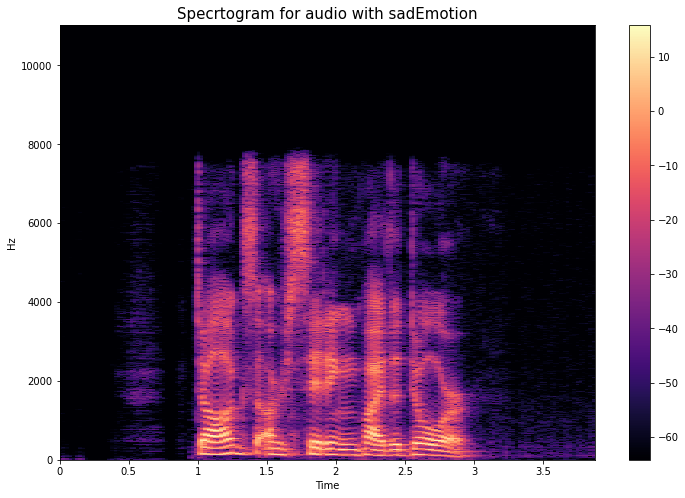

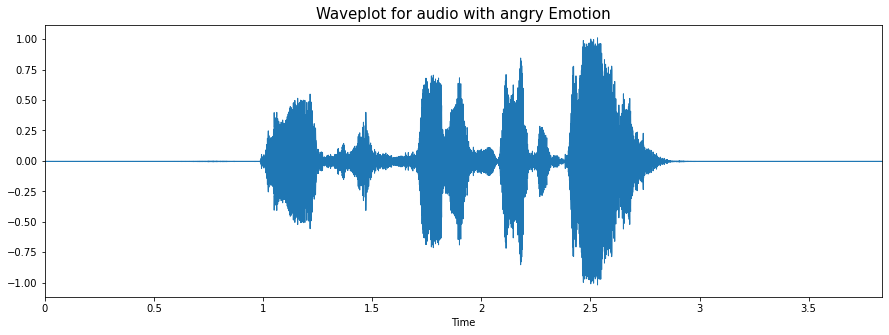

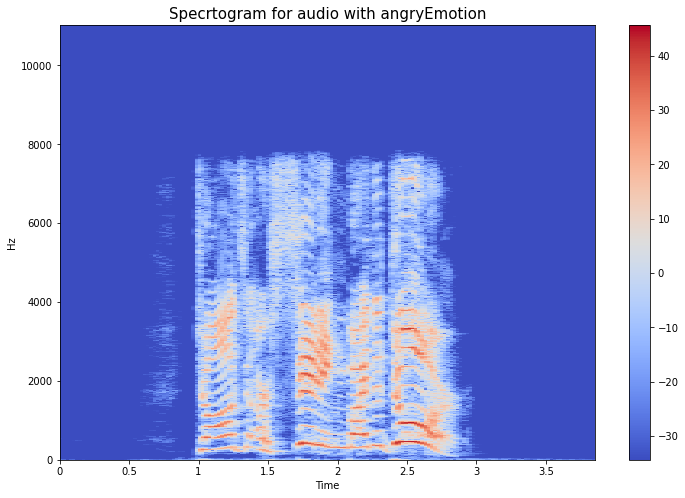

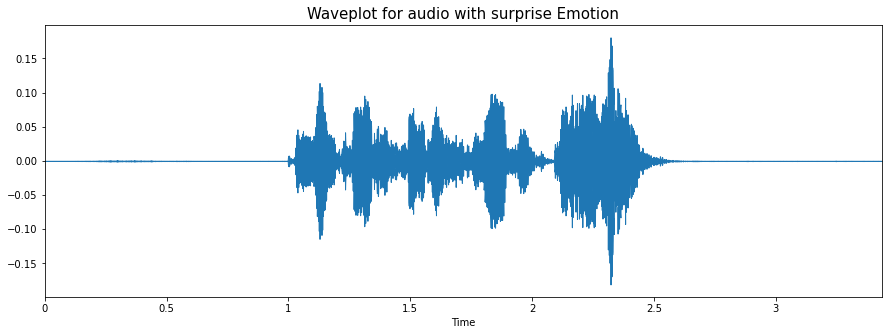

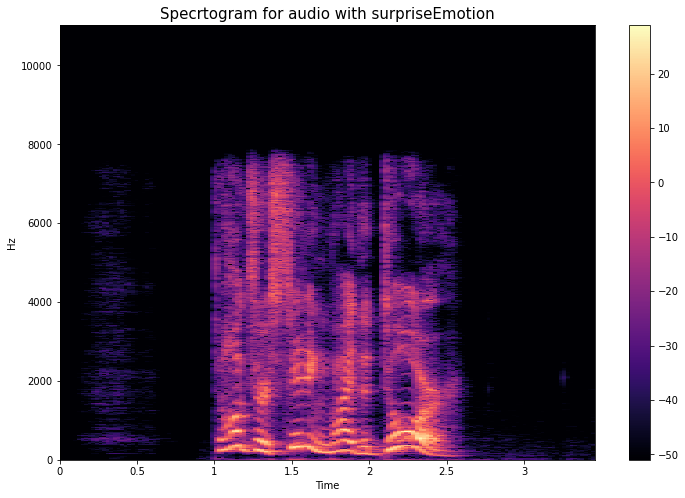

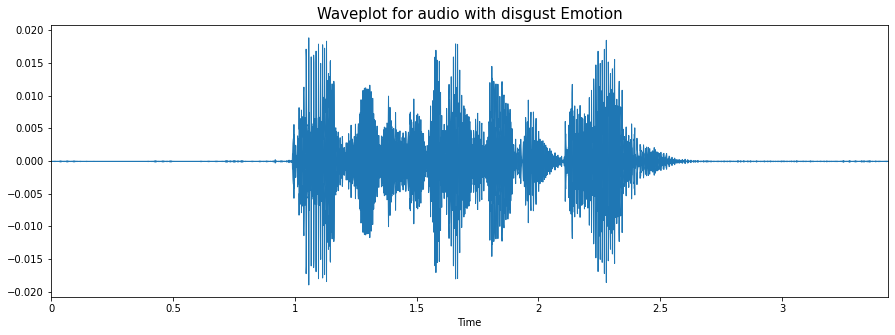

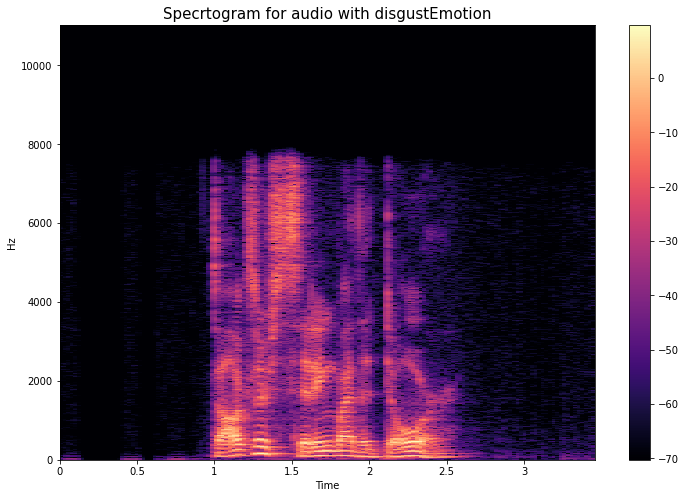

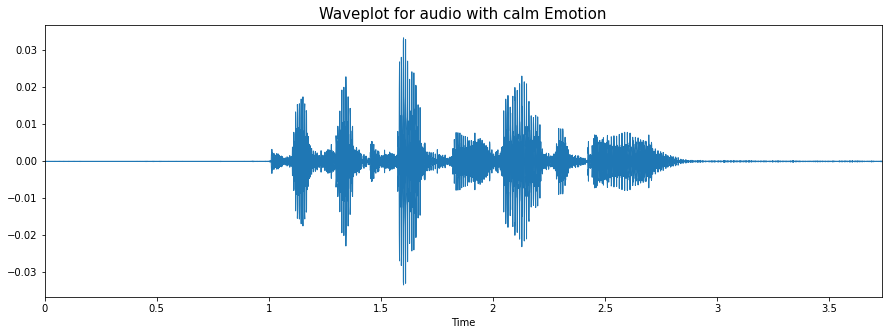

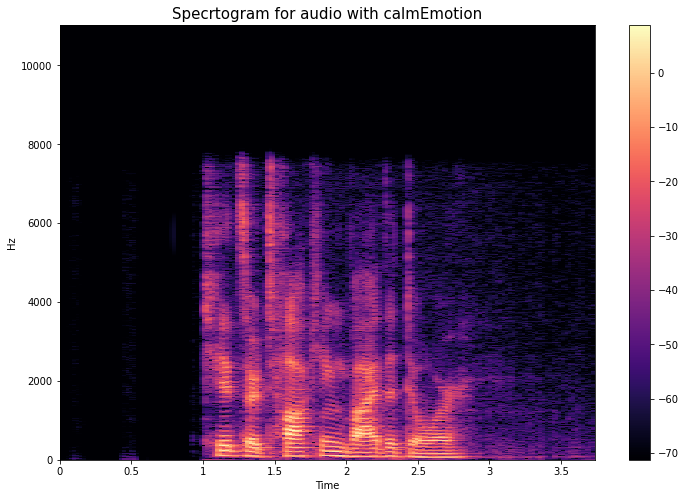

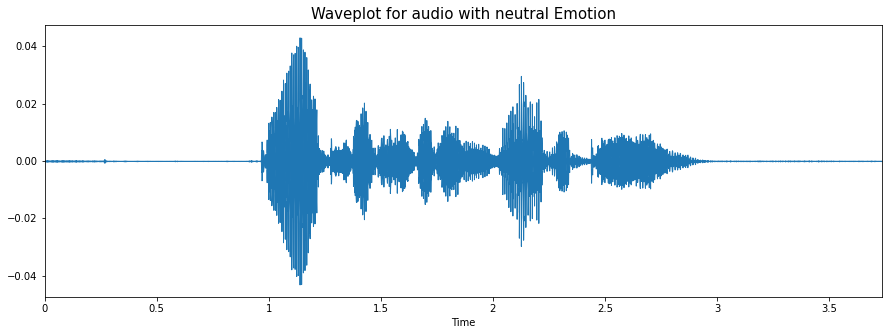

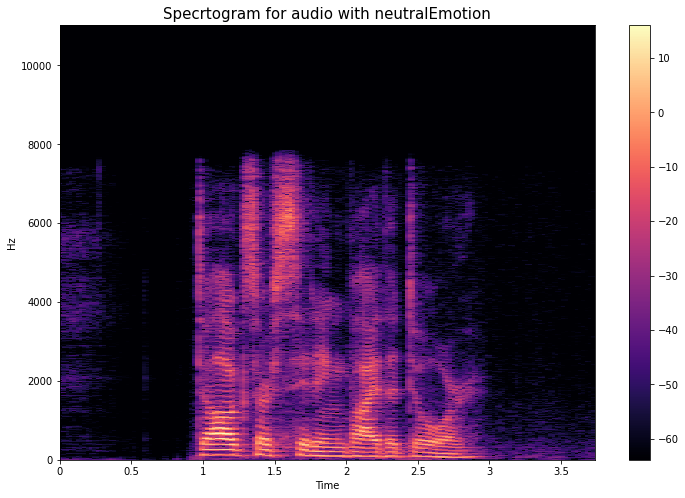

In [47]:
emotions =['fear','happy', 'sad', 'angry', 'surprise','disgust', 'calm','neutral']
for emotion in emotions:
  path = np.array(ravdess_df.Paths[ravdess_df.Emotions==emotion])[1]
  data, sampling_rate = librosa.load(path)
  create_waveform(data,sampling_rate, emotion)
  create_spectrogram(data, sampling_rate, emotion)
  Audio(path)
  print()

In [48]:
Audio(path)

In [49]:
ravdess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  1440 non-null   object
 1   Paths     1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


## DATA AUGMENTATION
Since our data set is not that big we will modify our existing dataset and generate synthetic data from audio, like injecting noises, shifting time, changing pitch and speed. \
This would make our model more generalized. An important thing to keep in mind is that, the augmented data must have the same label as the orignal data. 

In [50]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

In [51]:
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data,rate)

In [52]:
def pitch(data, sampling_rate, pitch_factor=0.7):
  return (librosa.effects.pitch_shift(data, sampling_rate, pitch_factor))

In [54]:
#checking for the techmique
path = np.array(ravdess_df.Paths)[1]
data, sampling_rate = librosa.load(path)

Simple audio without augmentation

Simple audio without modulations


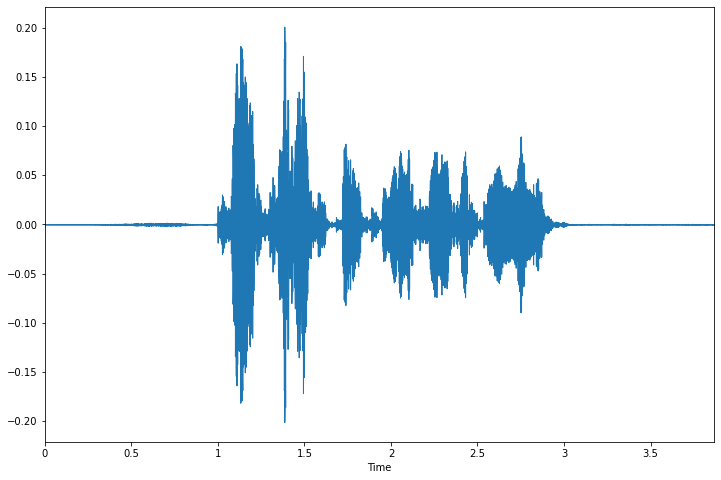

In [57]:
print('Simple audio without modulations')
plt.figure(figsize=(12,8))
librosa.display.waveplot(y=data, sr= sampling_rate)
Audio(path)

Injecting noise

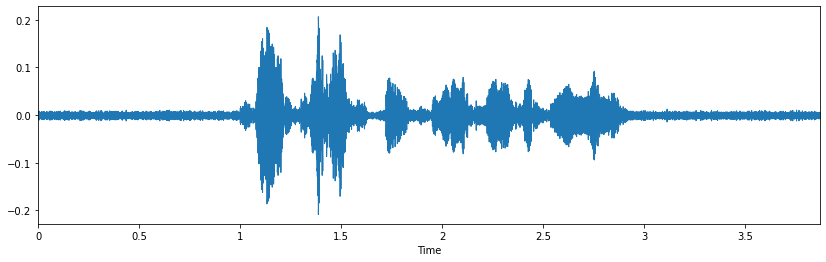

In [60]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr = sampling_rate)
Audio(x, rate=sampling_rate)

Stretching

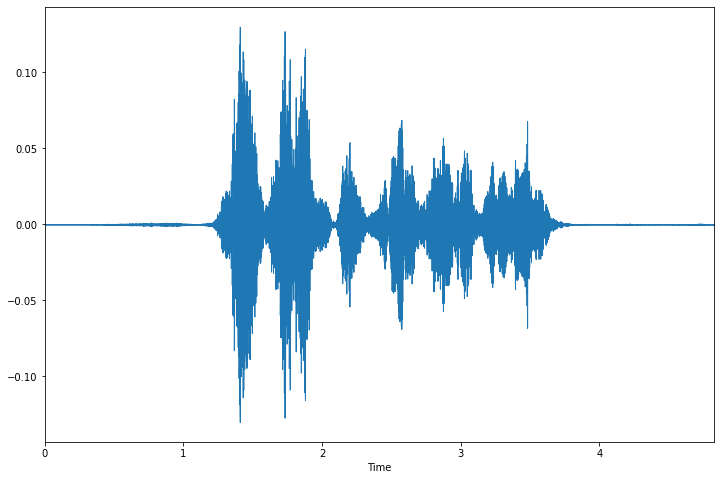

In [63]:
x = stretch(data)
plt.figure(figsize=(12,8))
librosa.display.waveplot(y=x, sr=sampling_rate)
Audio(x, rate = sampling_rate)

Pitching

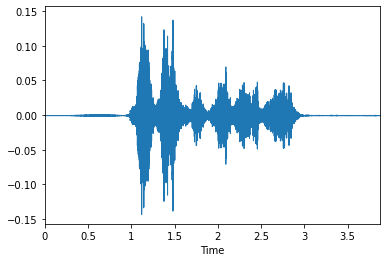

In [65]:
x = pitch(data,sampling_rate)
librosa.display.waveplot(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

## FEATURE EXTRACTION
The audio data provided to the model can not be understood by the model directly and hence we need to convert into an understandable format. For this we use feature extraction. \

1. Zero Crossing Rate: The rate of sign-changes of the signal during the duration of a particular frame.
2. Chroma_stft
3. MFCC: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
4. RMS value
5. MelSpectrogram( to train our model)

In [70]:
def feature_extraction(data):
  result = np.array([])

  #Zero Crossing Rate
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result,zcr))  #stacking horizontally

  #Chroma_stft
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
  result = np.hstack((result,chroma_stft))

  #mfcc     
  mfcc = np.mean(librosa.feature.mfcc(y=data,sr=sampling_rate).T, axis=0)
  result = np.hstack((result,mfcc))

  #Root mean square value
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result,rms))

  #melspectrogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T,axis=0)
  result = np.hstack((result,mel))

  return result


In [73]:
#duration and offset are used to take care that there is no audio in the beginning and in the end of each audio 
def get_features(path):
  data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)

  #without augmentation
  res1 = feature_extraction(data)
  result =  np.array(res1)

  #data with noise
  noise_data = noise(data)
  res2 = feature_extraction(noise_data)
  result = np.vstack((result,res2))

  #data with stretching and pitching
  new_data = stretch(data)
  pitch_data = pitch(new_data, sampling_rate)
  res3 = feature_extraction(pitch_data)
  result = np.vstack((result,res3))

  return result


In [74]:
X, y =[], []
for path, emotion in zip(ravdess_df.Paths, ravdess_df.Emotions):
  features = get_features(path)
  for element in features:
    X.append(element)       #appending the original and 2 augmented values into X
    y.append(emotion)

In [75]:
len(X), len(y), ravdess_df.Paths.shape

(4320, 4320, (1440,))

In [76]:
Features = pd.DataFrame(X)
Features['labels'] = y
Features.to_csv('feataures.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.152620,0.621990,0.590012,0.546752,0.594745,0.619289,0.583485,0.604850,0.679640,0.708601,0.776511,0.768906,0.717596,-645.546068,115.021518,-10.736350,39.879184,1.716741,7.033420,-9.180724,-5.605957,-8.837490,-0.299778,-5.565639,-2.952461,7.234363,-8.106415,3.984046,0.152710,-6.058333,-1.452474,2.688431,-4.056802,0.002401,0.000062,0.000054,0.001096,0.011266,0.010754,0.001606,...,0.000071,0.000050,0.000028,0.000017,0.000011,0.000006,0.000003,0.000006,5.284001e-06,0.000007,0.000008,0.000010,0.000006,0.000016,0.000017,0.000021,0.000023,0.000014,0.000006,0.000002,1.212889e-06,3.249752e-06,7.879730e-06,5.280099e-06,3.671383e-06,0.000001,3.472877e-08,1.488266e-10,4.650568e-12,4.053241e-12,3.621267e-12,3.286812e-12,3.028579e-12,2.822501e-12,2.658937e-12,2.532815e-12,2.436746e-12,2.370359e-12,2.329275e-12,sad
1,0.195245,0.643915,0.636216,0.638484,0.690847,0.662413,0.586404,0.620028,0.672234,0.723560,0.769891,0.761734,0.715346,-586.333245,78.047780,3.697925,25.350434,7.810946,-0.481121,-5.991455,-7.412044,-6.714898,-2.882103,-5.699880,-1.696436,3.795892,-5.522257,0.904371,0.328098,-6.826961,-0.705451,1.972752,-3.321609,0.002415,0.000063,0.000055,0.001097,0.011266,0.010740,0.001606,...,0.000072,0.000051,0.000028,0.000017,0.000011,0.000006,0.000003,0.000006,5.838295e-06,0.000008,0.000008,0.000010,0.000006,0.000017,0.000017,0.000021,0.000023,0.000014,0.000007,0.000002,1.674320e-06,3.700782e-06,8.253610e-06,5.760371e-06,4.144473e-06,0.000002,5.026405e-07,4.632706e-07,4.629802e-07,4.424263e-07,4.573574e-07,4.940910e-07,5.143496e-07,4.628062e-07,4.709485e-07,5.049486e-07,4.870505e-07,4.488405e-07,4.799067e-07,sad
2,0.093587,0.690709,0.585403,0.561306,0.525774,0.570753,0.591523,0.573438,0.618908,0.656555,0.684819,0.746942,0.740763,-703.409392,111.487899,-11.181558,40.591713,-1.814840,6.775666,-13.023871,-6.893228,-10.491651,-0.016362,-7.534581,1.032559,3.493402,-9.477644,5.036644,-3.492431,-5.532429,1.505259,1.835748,-5.917830,0.001183,0.000016,0.000013,0.000084,0.002528,0.003391,0.000414,...,0.000016,0.000016,0.000014,0.000007,0.000006,0.000003,0.000002,0.000001,6.824719e-07,0.000002,0.000001,0.000002,0.000002,0.000002,0.000002,0.000006,0.000003,0.000007,0.000005,0.000003,8.227795e-07,2.770832e-07,4.452183e-07,9.867211e-07,9.135898e-07,0.000001,5.676189e-07,6.851862e-08,1.089703e-09,3.152775e-12,2.045632e-12,1.829810e-12,1.730342e-12,1.710363e-12,1.606594e-12,1.603371e-12,1.836151e-12,2.673374e-12,3.361599e-12,sad
3,0.115176,0.492187,0.558598,0.539092,0.653133,0.643070,0.548534,0.506180,0.489159,0.533734,0.602395,0.646977,0.517862,-418.105433,96.669674,-30.619155,38.148347,-25.226106,3.222885,-28.429917,-0.789670,-16.121907,-4.765146,-6.688196,-11.059867,1.483875,-17.535336,-0.690448,-9.461962,-2.061334,-4.854085,-0.625818,-7.512371,0.019122,0.063204,0.001334,0.000336,0.000540,0.016818,0.134881,...,0.002214,0.001228,0.000920,0.000799,0.001062,0.001095,0.001314,0.001795,1.551847e-03,0.001274,0.003234,0.001972,0.001117,0.000789,0.001131,0.001256,0.001269,0.000796,0.000811,0.000805,7.844627e-04,8.893262e-04,1.302833e-03,1.625021e-03,6.248263e-04,0.000166,1.323867e-05,7.069009e-08,2.100381e-10,1.558884e-10,1.223164e-10,9.973540e-11,8.414333e-11,7.295311e-11,6.482076e-11,5.894417e-11,5.473015e-11,5.190972e-11,5.023711e-11,surprise
4,0.201981,0.591396,0.633071,0.632634,0.712970,0.705304,0.602103,0.560596,0.560668,0.596303,0.642568,0.705823,0.638913,-326.067721,45.784849,0.509453,11.828778,-3.547312,-9.017653,-11.728461,-6.191617,-8.299173,-5.531480,-5.465073,-6.860189,-4.051106,-8.640733,-4.151306,-3.624770,-5.024715,-2.425046,-2.752093,-5.139784,0.019526,0.063863,0.001561,0.000555,0.000708,0.017071,0.135089,...,0.002424,0.001463,0.001180,0.001061,0.001284,0.001330,0.00154

We have extracted the features of the audio signal that is understood by our model using data augmentation.

## DATA PREPARATION

In [77]:
X = Features.iloc[:,:-1].values
y = Features['labels'].values

We will have to encode the data as we have multiple classes

In [78]:
encoder = OneHotEncoder()
y =  encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

spliting our dataset into test and train set

In [81]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=True,shuffle = True)
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((3024, 162), (3024, 8), (1296, 162), (1296, 8))

Scaling our data

In [82]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 162), (3024, 8), (1296, 162), (1296, 8))

In [97]:
#expanding the dimensions 
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test,axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 162, 1), (3024, 8), (1296, 162, 1), (1296, 8))

## MODEL BUILDING

In [98]:
model = Sequential([
                    Conv1D(filters= 256, kernel_size=5, strides=1,padding='same', input_shape=(x_train.shape[1], 1)),
                    Activation('relu'),
                    MaxPool1D(pool_size=2),
                    BatchNormalization(),

                    Conv1D(filters=256, kernel_size=5, padding='same'),
                    Activation('relu'),
                    MaxPool1D(pool_size=2),
                    BatchNormalization(),
                    Dropout(0.8),

                    Conv1D(filters=128, kernel_size=5, padding='same'),
                    Activation('relu'),
                    MaxPool1D(pool_size=2),
                    BatchNormalization(),
                    Dropout(0.3),

                    Conv1D(filters=64, kernel_size=5, padding='same'),
                    Activation('relu'),
                    MaxPool1D(pool_size=2),
                    BatchNormalization(),
                    Dropout(0.5),

                    Flatten(),

                    Dense(32),
                    Activation('relu'),
                    Dense(8),
                    Activation('softmax')
])
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
activation_29 (Activation)   (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 81, 256)           1024      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 81, 256)           327936    
_________________________________________________________________
activation_30 (Activation)   (None, 81, 256)           0         
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 40, 256)          

In [99]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr = 0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_test,y_test), callbacks=[rlrp])

Train on 3024 samples, validate on 1296 samples
Epoch 1/60
3024/3024 [==============================] - 19s 6ms/step - loss: 2.2801 - accuracy: 0.1839 - val_loss: 2.0690 - val_accuracy: 0.1705
Epoch 2/60
3024/3024 [==============================] - 18s 6ms/step - loss: 1.9946 - accuracy: 0.2192 - val_loss: 2.1046 - val_accuracy: 0.1674
Epoch 3/60
3024/3024 [==============================] - 18s 6ms/step - loss: 1.9322 - accuracy: 0.2444 - val_loss: 2.1231 - val_accuracy: 0.1644
Epoch 4/60
3024/3024 [==============================] - 18s 6ms/step - loss: 1.8357 - accuracy: 0.2791 - val_loss: 2.1724 - val_accuracy: 0.1373
Epoch 5/60
3024/3024 [==============================] - 18s 6ms/step - loss: 1.8336 - accuracy: 0.2794 - val_loss: 2.1296 - val_accuracy: 0.2184
Epoch 6/60
3024/3024 [==============================] - 18s 6ms/step - loss: 1.7746 - accuracy: 0.3138 - val_loss: 2.2022 - val_accuracy: 0.2184
Epoch 7/60
3024/3024 [==============================] - 18s 6ms/step - loss: 1.757

In [100]:
acc = model.evaluate(x_test,y_test)
print("Accuracy of model on test set ",acc[1]*100)

1296/1296 [==============================] - 2s 1ms/step
Accuracy of model on test set  57.175928354263306


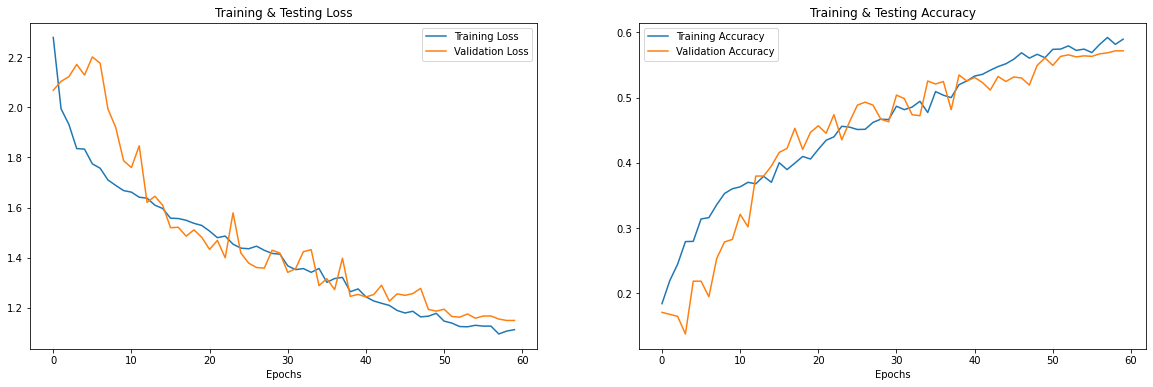

In [101]:
epochs = [i for i in range(60)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss,label='Training Loss')
ax[0].plot(epochs, val_loss, label = 'Validation Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')


ax[1].plot(epochs, train_acc,label='Training Accuracy')
ax[1].plot(epochs, val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')
plt.show()

Predicting on test data

In [102]:
pred = model.predict(x_test)
y_pred = encoder.inverse_transform(pred)
y_test = encoder.inverse_transform(y_test)

In [104]:
df = pd.DataFrame(columns = ['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()


df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,surprise,surprise
3,calm,calm
4,calm,happy
5,fear,neutral
6,neutral,surprise
7,sad,fear
8,calm,calm
9,calm,calm


Printing a confusion matrix for the same


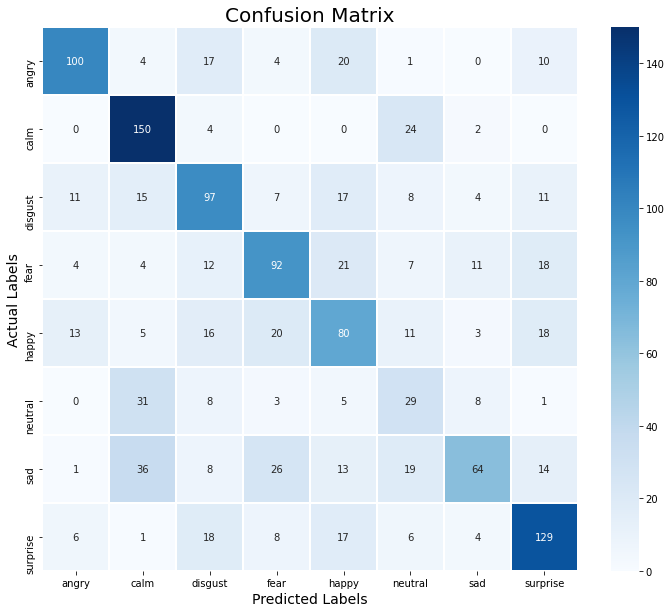

In [105]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

Printing recall value for each class


In [106]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.64      0.69       156
        calm       0.61      0.83      0.70       180
     disgust       0.54      0.57      0.55       170
        fear       0.57      0.54      0.56       169
       happy       0.46      0.48      0.47       166
     neutral       0.28      0.34      0.31        85
         sad       0.67      0.35      0.46       181
    surprise       0.64      0.68      0.66       189

    accuracy                           0.57      1296
   macro avg       0.56      0.56      0.55      1296
weighted avg       0.58      0.57      0.57      1296

